In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"thegrapeeater","key":"fea9146c8089d6c2ed79048a1579ed39"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip asl-alphabet.zip -d asl_dataset

Archive:  asl-alphabet.zip
replace asl_dataset/asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install mediapipe

In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
from tqdm import tqdm
import torch

base_path = "/content/asl_dataset/asl_alphabet_train/asl_alphabet_train"
output_csv = "/content/mediapipe_landmarks.csv"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None

        image_tensor = torch.tensor(image).to(device)

        image_resized = torch.nn.functional.interpolate(
            image_tensor.permute(2, 0, 1).unsqueeze(0).float(),
            size=(224, 224),
            mode='bilinear',
            align_corners=False,
        )[0].permute(1, 2, 0).byte().cpu().numpy()

        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        return image_rgb
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None


def extract_landmarks(label, image_path):
    try:

        image = preprocess_image(image_path)
        if image is None:
            return None

        results = hands.process(image)

        if results.multi_hand_landmarks:
            landmarks = []
            for lm in results.multi_hand_landmarks[0].landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            return [label] + landmarks
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

    return None

all_image_paths = []
labels = os.listdir(base_path)
for label in labels:
    class_path = os.path.join(base_path, label)
    if not os.path.isdir(class_path):
        continue
    image_files = [os.path.join(class_path, file) for file in os.listdir(class_path)]
    all_image_paths.extend([(label, image_path) for image_path in image_files])

data = []
for label, image_path in tqdm(all_image_paths, desc="Processing Images", unit="image"):
    result = extract_landmarks(label, image_path)
    if result:
        data.append(result)

columns = ['label'] + [f'{axis}{i}' for i in range(21) for axis in ('x', 'y', 'z')]
landmarks_df = pd.DataFrame(data, columns=columns)
landmarks_df.to_csv(output_csv, index=False)

print(f"Landmarks saved to {output_csv}")


Using device: cuda


Processing Images: 100%|██████████| 87000/87000 [39:38<00:00, 36.58image/s]


Landmarks saved to /content/mediapipe_landmarks.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/mediapipe_landmarks.csv")
print(df.head())
print("Total rows:", len(df))

  label        x0        y0            z0        x1        y1        z1  \
0     H  0.561390  0.593353  8.921819e-07  0.589437  0.519249 -0.060993   
1     H  0.702030  0.678528  5.440270e-07  0.718671  0.610288 -0.033318   
2     H  0.786393  0.837909  2.306183e-06  0.842627  0.718367 -0.128309   
3     H  0.646543  0.780220  8.712753e-07  0.676890  0.713843 -0.048354   
4     H  0.651010  0.569642  1.132853e-06  0.700392  0.494208 -0.075689   

         x2        y2        z2  ...       z17       x18       y18       z18  \
0  0.534030  0.430327 -0.082453  ... -0.065364  0.362976  0.519273 -0.143395   
1  0.688457  0.541112 -0.043681  ... -0.041763  0.559799  0.594529 -0.093937   
2  0.749081  0.579878 -0.180529  ... -0.089907  0.477674  0.745844 -0.223331   
3  0.650443  0.634998 -0.067141  ... -0.054736  0.487287  0.687100 -0.119205   
4  0.651922  0.397919 -0.104632  ... -0.074785  0.462795  0.494786 -0.160661   

        x19       y19       z19       x20       y20       z20  
0  0

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

output_csv = "/content/mediapipe_landmarks.csv"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
batch_size = 32
random_seed = 42

class ASLDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data['label']
        self.features = self.data.drop(columns=['label']).values
        self.label_mapping = {label: idx for idx, label in enumerate(self.labels.unique())}  # Map labels to indices
        self.data['label'] = self.data['label'].map(self.label_mapping)  # Convert labels to numeric indices

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.features[idx].astype(np.float32)
        label = self.data['label'].iloc[idx]
        return torch.tensor(features), torch.tensor(label, dtype=torch.long)

asl_dataset = ASLDataset(output_csv)

dataset_size = len(asl_dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    asl_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 45399
Validation dataset size: 9728
Test dataset size: 9730


In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

input_size = len(asl_dataset[0][0])
num_classes = len(asl_dataset.label_mapping)
model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


Epoch [1/10], Train Loss: 1.3035, Val Loss: 0.5772, Val Accuracy: 85.49%
Epoch [2/10], Train Loss: 0.4606, Val Loss: 0.3979, Val Accuracy: 90.34%
Epoch [3/10], Train Loss: 0.3255, Val Loss: 0.3008, Val Accuracy: 94.19%
Epoch [4/10], Train Loss: 0.2529, Val Loss: 0.2373, Val Accuracy: 94.92%
Epoch [5/10], Train Loss: 0.2033, Val Loss: 0.1982, Val Accuracy: 94.92%
Epoch [6/10], Train Loss: 0.1707, Val Loss: 0.1815, Val Accuracy: 95.58%
Epoch [7/10], Train Loss: 0.1497, Val Loss: 0.1410, Val Accuracy: 97.09%
Epoch [8/10], Train Loss: 0.1312, Val Loss: 0.1507, Val Accuracy: 95.80%
Epoch [9/10], Train Loss: 0.1231, Val Loss: 0.1242, Val Accuracy: 96.95%
Epoch [10/10], Train Loss: 0.1068, Val Loss: 0.1136, Val Accuracy: 97.05%


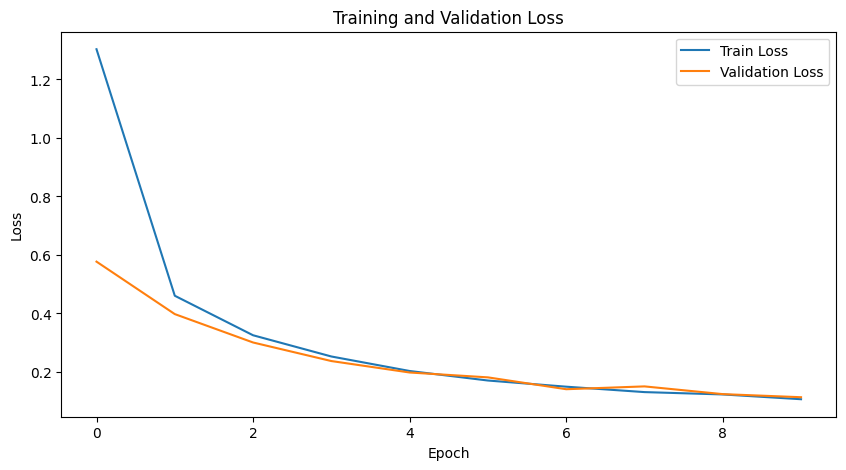

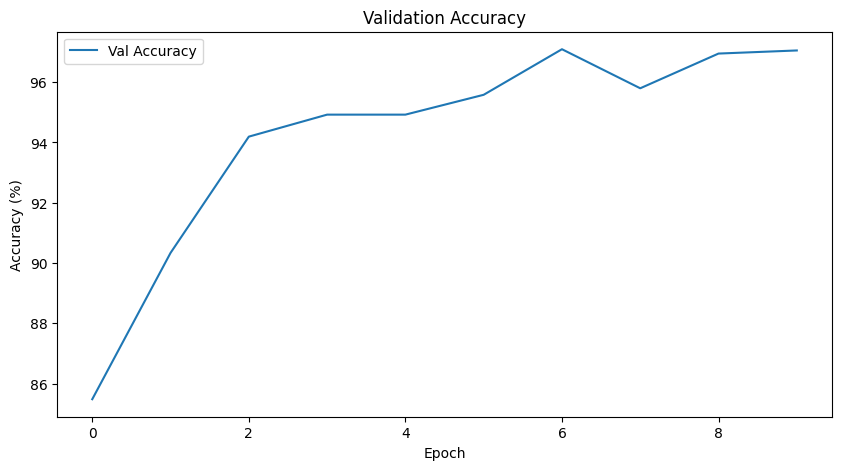

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_acc:.2f}%")

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


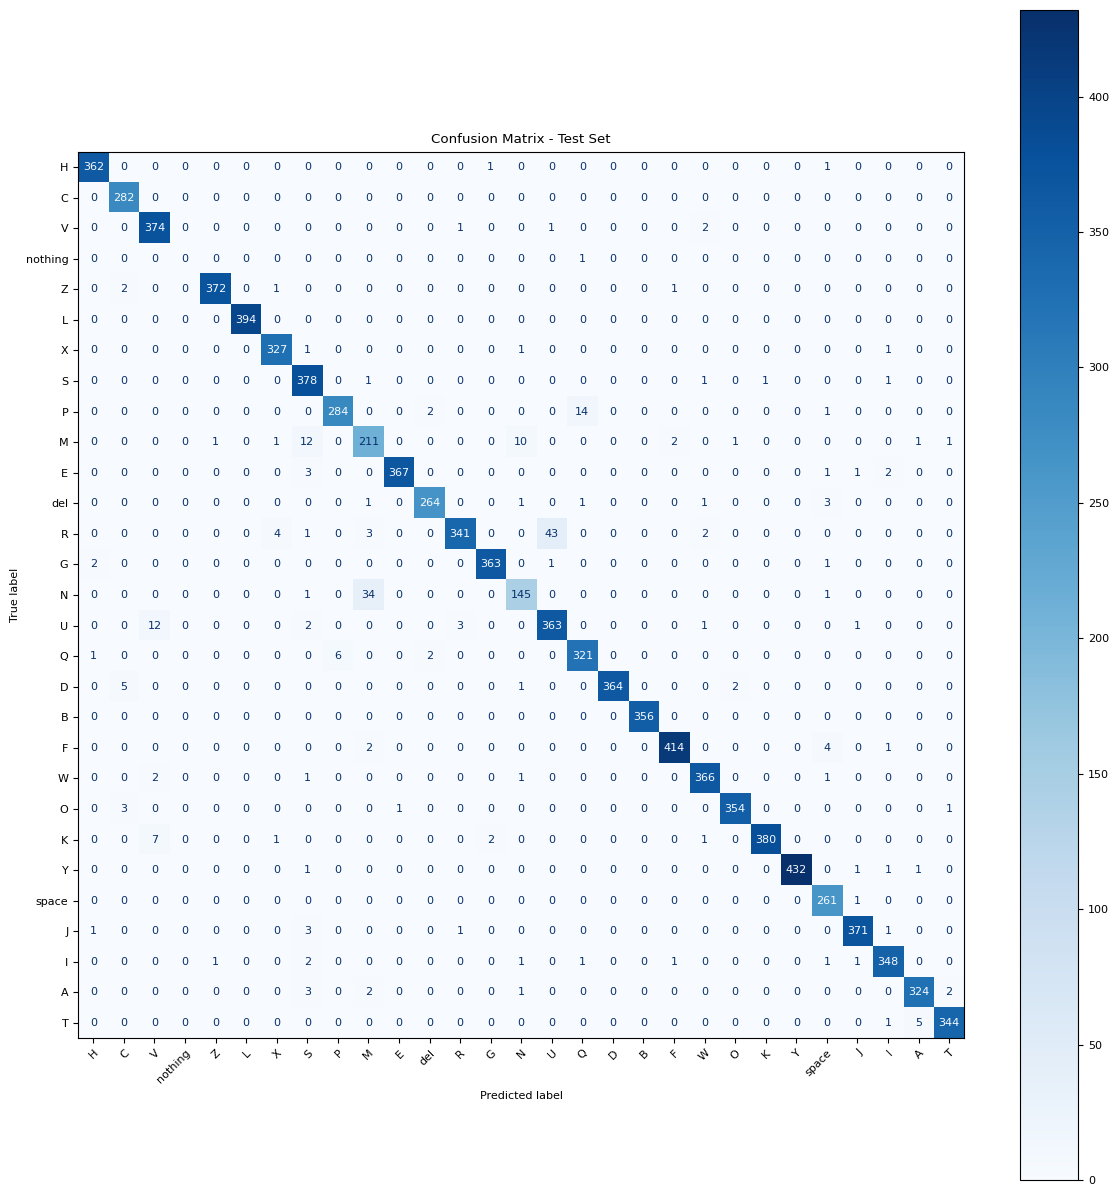

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=asl_dataset.label_mapping)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=asl_dataset.label_mapping))


Test Accuracy: 97.25%
Classification Report:
              precision    recall  f1-score   support

           H       0.99      0.99      0.99       364
           C       0.97      1.00      0.98       282
           V       0.95      0.99      0.97       378
     nothing       0.00      0.00      0.00         1
           Z       0.99      0.99      0.99       376
           L       1.00      1.00      1.00       394
           X       0.98      0.99      0.98       330
           S       0.93      0.99      0.96       382
           P       0.98      0.94      0.96       301
           M       0.83      0.88      0.85       240
           E       1.00      0.98      0.99       374
         del       0.99      0.97      0.98       271
           R       0.99      0.87      0.92       394
           G       0.99      0.99      0.99       367
           N       0.90      0.80      0.85       181
           U       0.89      0.95      0.92       382
           Q       0.95      0.97   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model_save_path = "/content/gesture_classifier.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/gesture_classifier.pth


In [ ]:
import joblib

label_mapping_save_path = "/content/label_mapping.pkl"

joblib.dump(asl_dataset.label_mapping, label_mapping_save_path)
print(f"Label mapping saved to {label_mapping_save_path}")


Label mapping saved to /content/label_mapping.pkl
